Notebook correspondant à la partie 4.2 du rapport, pour la résolution de l'équation avec amortissement sur les 3 composantes simultanément
\begin{equation}
\left\{
    \begin{aligned}
        \frac{dM_x}{dt} &=-\omega_z M_y - \lambda(M_z \frac{dM_y}{dt} - M_y \frac{dM_z}{dt}) \\
        \frac{dM_y}{dt} &= \omega_z M_x - \lambda(M_x \frac{dM_z}{dt} - M_z \frac{dM_x}{dt}) \\
        \frac{dM_z}{dt} &= - \lambda(M_y \frac{dM_x}{dt} - M_x \frac{dM_y}{dt})
    \end{aligned}
\right.
\end{equation}


In [43]:
#imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Physical parameters

In [44]:
M_0 = tf.constant([1,0,0], dtype='float32')
W = 2*np.pi
lamb = 0.3

Training parameters

In [45]:
N = 32 #number of samples for the independant variable
t_a = -1
t_b = 1
training_points = np.linspace(t_a, t_b,N)
training_points = tf.convert_to_tensor(training_points, dtype=tf.float32)

load_model = True
load_filename = "models/resolution_sans_projection"
save_model = False
save_filename = "models/3_NN_lambda=0.3"
learning_rate = 1e-4
epochs = 0
display_step = min(max(1,epochs//100), 1000)

Initializing the network

In [46]:
# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_output = 3    # output layer number of neurons

#model definition :
model = tf.keras.Sequential([
  tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.sigmoid, input_shape=(n_input,)),  # input shape required
  tf.keras.layers.Dense(n_output)
])

if load_model :
    model = tf.keras.models.load_model(load_filename)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Loss function
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape


In [47]:
def loss_function(model, input_tensor, M_0):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_tensor)
        output = model(input_tensor)
        Mx = M_0[0]+input_tensor*output[:,0]
        My = M_0[1]+input_tensor*output[:,1]
        Mz = M_0[2]+input_tensor*output[:,2]

    dMx = tape.gradient(Mx, input_tensor)
    dMy = tape.gradient(My, input_tensor)
    dMz = tape.gradient(Mz, input_tensor)

    ex = dMx + W*My + lamb*(Mz*dMy - My*dMz)
    ey = dMy - W*Mx + lamb*(Mx*dMz - Mz*dMx)
    ez = dMz + lamb*(My*dMx - Mx*dMy)

    return tf.reduce_mean(ex**2 + ey**2 + ez**2)

Gradient of loss

In [48]:
def grad(model, input_tensor, M_0):
    with tf.GradientTape() as tape:
        loss_value = loss_function(model, input_tensor, M_0)

    gradient = tape.gradient(loss_value, model.trainable_variables)

    return loss_value, gradient

Training the neural network

In [49]:
optimizer = tf.keras.optimizers.SGD(learning_rate=7e-3)
losses = []
epochs_displayed = []

for epoch in range(epochs) :
    loss_value, grads = grad(model, training_points, M_0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % display_step == 0 :
        print("Loss after",epoch,"/",epochs,"epochs :",loss_value.numpy())
        losses.append(loss_value.numpy())
        epochs_displayed.append(epoch)

loss_value, grads = grad(model, training_points, M_0)
print("Final loss after",epochs,"epochs :",loss_value.numpy())
losses.append(loss_value.numpy())
epochs_displayed.append(epochs)

Final loss after 0 epochs : 0.024565775


In [50]:
if save_model :
    model.save(save_filename)

Plot the evolution of loss

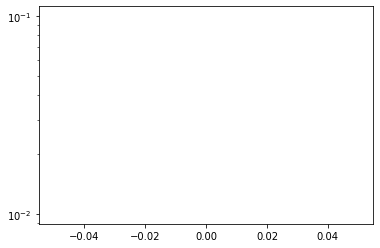

In [51]:
plt.plot(epochs_displayed, losses)
plt.yscale('log')
plt.show()


Compute the analytic solution

In [60]:
nb_plotting_points = 200
plotting_points = np.linspace(t_a,t_b,nb_plotting_points)
plotting_points = tf.convert_to_tensor(plotting_points, dtype=tf.float32)

time_factor = 1 + lamb**2

#for plotting_points
K = (M_0[2]-1) / (M_0[2]+1)
exp_vector = tf.exp(-lamb*W*plotting_points/time_factor)
F = exp_vector*(K-1)/(K*exp_vector**2-1)

Mx_ana =tf.multiply( F,(  tf.cos(W*plotting_points/time_factor)*M_0[0] - tf.sin(W*plotting_points/time_factor)*M_0[1]))
My_ana = tf.multiply(F,( tf.sin(W*plotting_points/time_factor)*M_0[0] + tf.cos(W*plotting_points/time_factor)*M_0[1]))
Mz_ana = (1+K*exp_vector**2) / (1-K*exp_vector**2)

#for training_points
K = (M_0[2]-1) / (M_0[2]+1)
exp_vector = tf.exp(-lamb*W*training_points/time_factor)
F = exp_vector*(K-1)/(K*exp_vector**2-1)

Mx_training =tf.multiply( F,(  tf.cos(W*training_points/time_factor)*M_0[0] - tf.sin(W*training_points/time_factor)*M_0[1]))
My_training = tf.multiply(F,( tf.sin(W*training_points/time_factor)*M_0[0] + tf.cos(W*training_points/time_factor)*M_0[1]))
Mz_training = (1+K*exp_vector**2) / (1-K*exp_vector**2)


Plot the estimation and the analytic solution

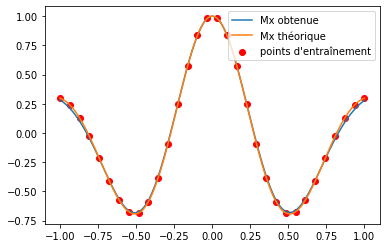

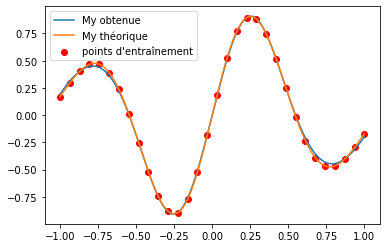

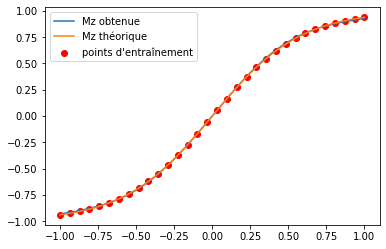

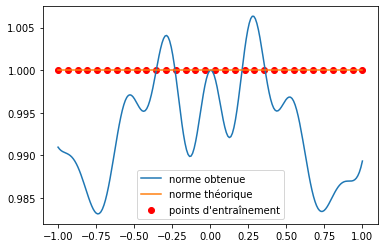

In [61]:
#neural network estimation
output = model(plotting_points)
Mx_NN = M_0[0]+plotting_points*output[:,0]
My_NN = M_0[1]+plotting_points*output[:,1]
Mz_NN = M_0[2]+plotting_points*output[:,2]

plt.plot(plotting_points, Mx_NN, label='Mx obtenue')
plt.plot(plotting_points, Mx_ana, label = 'Mx théorique')
plt.scatter(training_points, Mx_training, label = "points d'entraînement", color='red')
plt.legend()
plt.show()

plt.plot(plotting_points, My_NN, label='My obtenue')
plt.plot(plotting_points, My_ana, label = 'My théorique')
plt.scatter(training_points, My_training, label = "points d'entraînement", color='red')
plt.legend()
plt.show()

plt.plot(plotting_points, Mz_NN, label='Mz obtenue')
plt.plot(plotting_points, Mz_ana, label = 'Mz théorique')
plt.scatter(training_points, Mz_training, label = "points d'entraînement", color='red')
plt.legend()
plt.show()

norm = tf.sqrt(Mx_NN**2 + My_NN**2 + Mz_NN**2)
plt.plot(plotting_points, norm, label='norme obtenue')
plt.plot(plotting_points, np.ones((nb_plotting_points)), label = 'norme théorique')
plt.scatter(training_points, np.ones((N)), label = "points d'entraînement", color='red')
plt.legend()
plt.show()